# Notebook for Kaggle competition "Titanic"
Author: Dirk Ulbricht, dirk@neuefische.de

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
plt.style.use('seaborn')


### Variable description (from Kaggle)

| Variable | Definition                                 | Key                                            | Type        |
|:----------|:--------------------------------------------|:------------------------------------------------|-------------|
| Survived | Survival                                   | 0 = No, 1 = Yes                                | nominal     |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      | ordinal     |
| Sex      | Sex                                        |                                                | dichotomous |
| Age      | Age in years                               |                                                | ratio       |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                | ratio       |
| Parch    | # of parents / children aboard the Titanic |                                                |             |
| Ticket   | Ticket number                              |                                                | nominal     |
| Fare     | Passenger fare                             |                                                | ratio       |
| Cabin    | Cabin number                               |                                                | nominal     |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton | nominal     |


In [106]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

### Type of data and missings

In [107]:
# Getting a first idea of the data
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [109]:
missing = pd.DataFrame(train.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/train.shape[0]*100,1)
missing[missing.Number!=0]


,Number,Percentage
Age,177,19.9
Cabin,687,77.1
Embarked,2,0.2


Of the 12 variables 3 have missing values. 
- **Embarked** has only 2 instances or .2 percent missing values 
- **Cabin** has no values for 77.1 percent of instances
- **Age** is not known in 19.9 percent of all cases

## Getting some basic statistics

In [110]:
train.describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


$r_{x,y} = \frac{\Sigma_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\Sigma_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\Sigma_{i=1}^{n}(y_i-\bar{y})^2}}=\frac{Cov(x,y)}{Std(x)\times Std(y)}$


### Correlation analyis

In [111]:
continuous_var = list(train.select_dtypes(
                        ['int64','float64','bool']).columns.values)
continuous_var.remove('PassengerId')
categorical_var=['Sex','Embarked']

(891, 11)

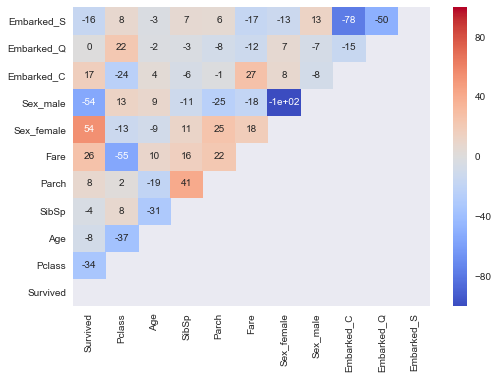

In [112]:
train_dum=pd.get_dummies(train[continuous_var+categorical_var].copy())
mask = np.triu(train_dum.corr())
ax = sns.heatmap(round(train_dum.corr()*100,0),annot=True,mask=mask,cmap='coolwarm')
ax.set_ylim((0,11))
train_dum.shape

C:\Users\dirku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\dirku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


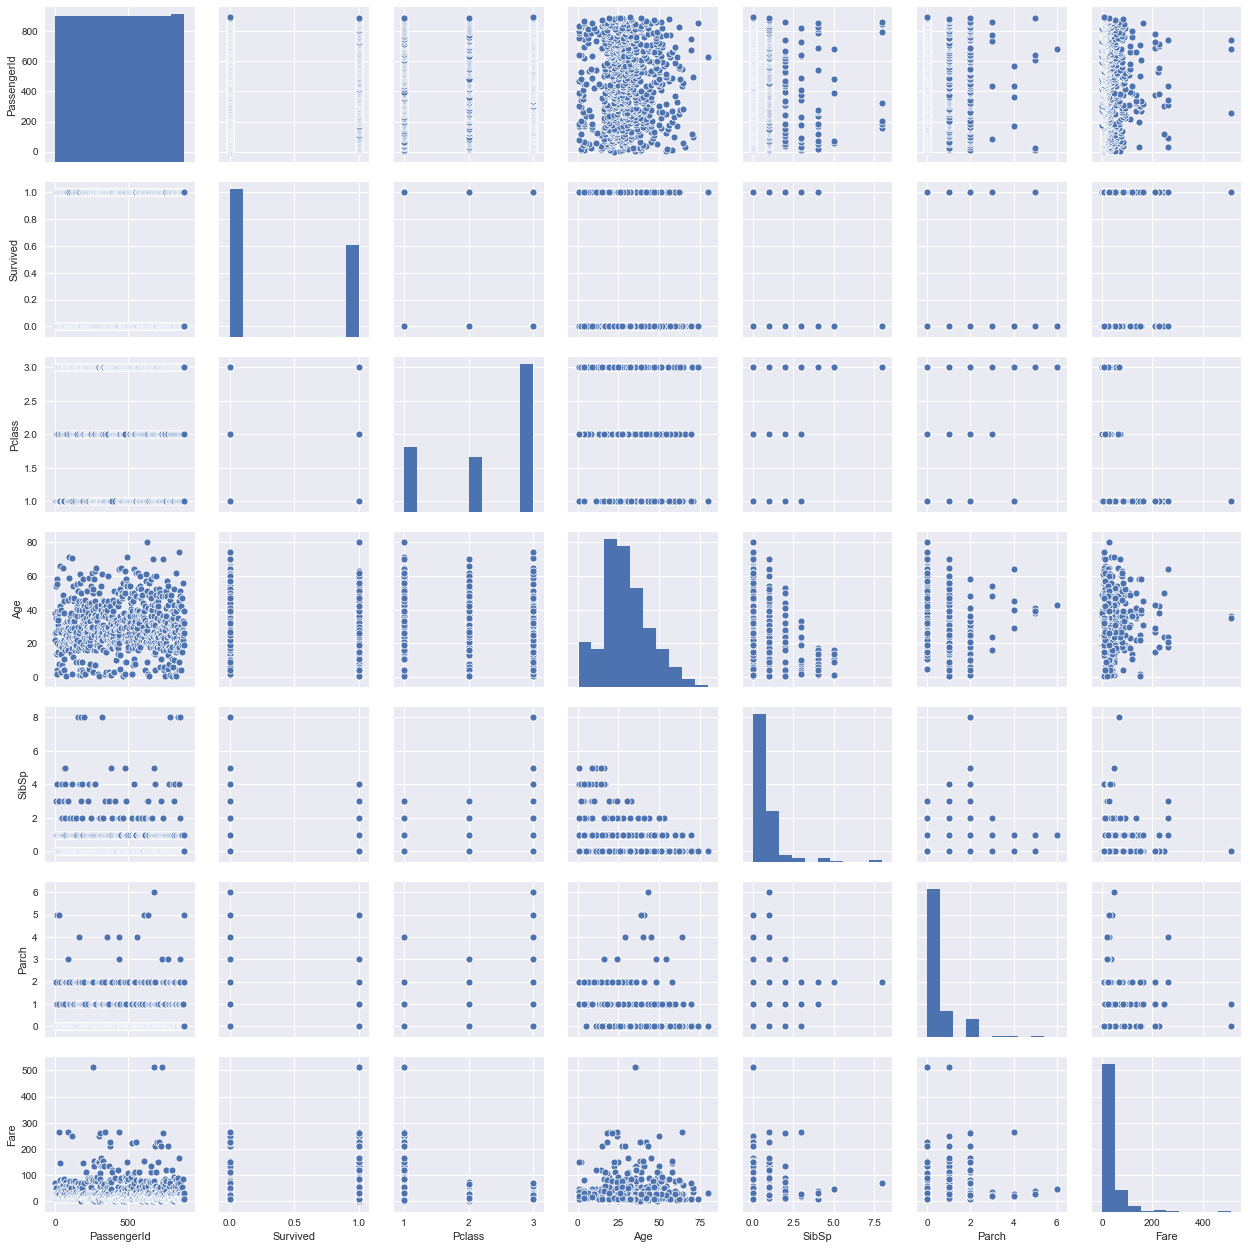

In [114]:
sns.pairplot(train)

### Histograms 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0F701290>,
      dtype=object)

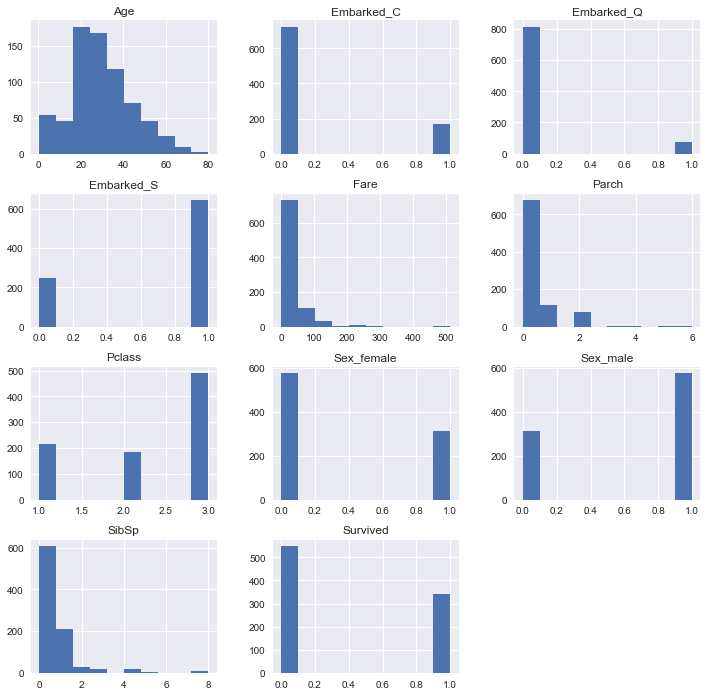

In [116]:
train_dum.hist(figsize=(12,12))

# Looking at variable individually creating new features

### Survivors and casualties

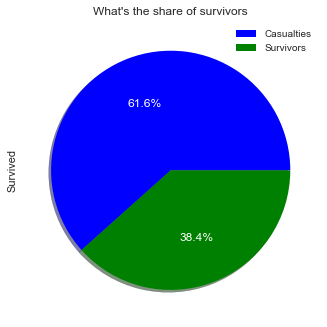

In [117]:
Fig_age_survivial = pd.value_counts(train.Survived).plot.pie(autopct='%1.1f%%', shadow=True,colors=['blue','green'],
                                  textprops=dict(color="w",size='12'))
plt.title('What\'s the share of survivors')
plt.legend(['Casualties','Survivors'])
#plt.savefig('Survived_pie.png')

### Siblings-Spouses (SibSp) and Parents-Children (Parch)
Let's see if creating a new feature **_relatives_** is helpful for the analysis

    Siblings & Spouse  Parents & children  Relatives
0                68.2                76.1       60.3
1                23.5                13.2       18.1
2                 3.1                 9.0       11.4
3                 1.8                 0.6        3.3
4                 2.0                 0.4        1.7
5                 0.6                 0.6        2.5
6                 NaN                 0.1        1.3
7                 NaN                 NaN        0.7
8                 0.8                 NaN        NaN
10                NaN                 NaN        0.8


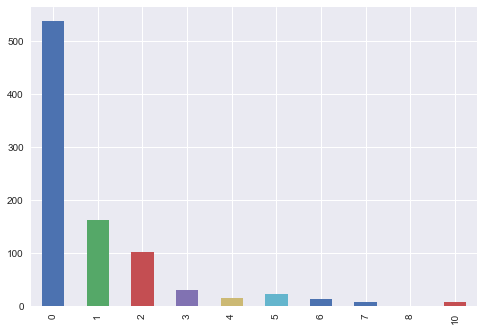

In [119]:
train['relatives'] = train.SibSp + train.Parch
test['relatives'] = test.SibSp + test.Parch
Relatives = pd.DataFrame(train.SibSp.value_counts()).merge(
    pd.DataFrame(train.Parch.value_counts())
               ,left_index=True
               ,right_index=True
               ,how='outer'
              ).merge(
    pd.DataFrame(train.relatives.value_counts())
                ,left_index=True
                 ,right_index=True
                 ,how='outer'
)
Relatives.columns = ['Siblings & Spouse','Parents & children','Relatives']
print(round(Relatives/train.shape[0]*100,1))
Relatives.Relatives.plot(kind='bar')

## Name

Some of the passengers have a certain societal rank that can be identified by the title given in the passenger list. 
1. From [wikipedia](https://en.wikipedia.org/wiki/Master_(form_of_address)) "**Master** was used in England for men of some rank, especially "free masters" of a trade guild and by any manual worker or servant employee addressing his employer (his master), but also generally by those lower in status to gentlemen, priests, or scholars."
2. There are some Drs., Reverends, Col., Majors. and a Capt.
3. Some of the women were wed (Mrs, Mme, some unwed (Miss, Ms and Mlle)

In [120]:
train.Name[21:40]

21                                Beesley, Mr. Lawrence
22                          McGowan, Miss. Anna "Annie"
23                         Sloper, Mr. William Thompson
24                        Palsson, Miss. Torborg Danira
25    Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...
26                              Emir, Mr. Farred Chehab
27                       Fortune, Mr. Charles Alexander
28                        O'Dwyer, Miss. Ellen "Nellie"
29                                  Todoroff, Mr. Lalio
30                             Uruchurtu, Don. Manuel E
31       Spencer, Mrs. William Augustus (Marie Eugenie)
32                             Glynn, Miss. Mary Agatha
33                                Wheadon, Mr. Edward H
34                              Meyer, Mr. Edgar Joseph
35                       Holverson, Mr. Alexander Oskar
36                                     Mamee, Mr. Hanna
37                             Cann, Mr. Ernest Charles
38                   Vander Planke, Miss. August

In [121]:
title = train.Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0].strip()
                   )
title_test = test.Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0].strip()
                   )
title.value_counts()#.head(100)


Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Mme               1
the Countess      1
Don               1
Sir               1
Ms                1
Jonkheer          1
Capt              1
Lady              1
Name: Name, dtype: int64

##### Creating new column title_honor

In [122]:
# first, drop mrs, mr, miss and mme
title_honor = list(title.unique())
title_drop = ['Mrs', 'Mr', 'Miss', 'Mme','Mlle']
for a in title_drop: title_honor.remove(a)
train['title_honor']=[a in title_honor for a in title]
test['title_honor']=[a in title_honor for a in title_test]

##### Creating new column unmarried_women

In [123]:
train[train.Sex=='female'].Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0]
                   ).value_counts()#.

 Miss            182
 Mrs             125
 Mlle              2
 Mme               1
 the Countess      1
 Dr                1
 Lady              1
 Ms                1
Name: Name, dtype: int64

All women that do not have the title Mrs or Mme will be labeled as unmarried.

In [124]:
train['unmarried_woman']=train.Name.map(
    lambda x:  1-bool(re.search('Mrs.|Mlle.',x)))
test['unmarried_woman']=test.Name.map(
    lambda x:  1-bool(re.search('Mrs.|Mlle.',x)))

### Ticket and Fare
- Which passengers had the same ticket number?
- Do we have to adjust the fare for the number of people how shared the same ticket number?
- Does the ticket number give any hint to where the cabins of the passengers were?

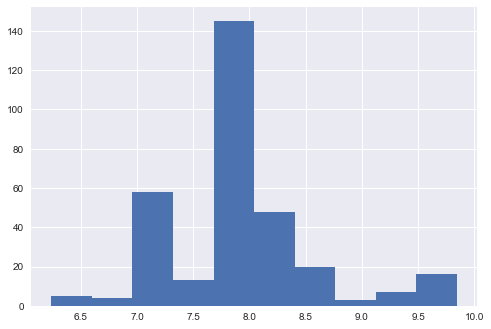

In [125]:
train.sort_values(by=['Ticket'],ascending=False)
train.Fare[(train.Fare>5) & (train.Fare<10)].hist()

Text(0.5, 1.0, '3rd Class')

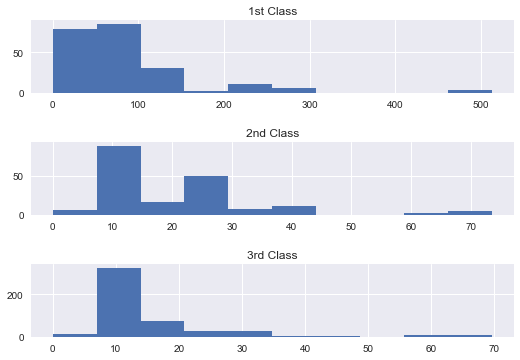

In [126]:
fig, axes = plt.subplots(3,1)
fig.tight_layout(pad=3.0)
train.Fare[train.Pclass==1].hist(ax=axes[0])
axes[0].set_title('1st Class')
train.Fare[train.Pclass==2].hist(ax=axes[1])
axes[1].set_title('2nd Class')
train.Fare[train.Pclass==3].hist(ax=axes[2])
axes[2].set_title('3rd Class')

In [127]:
train.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [128]:
ticket_prefix = train.Ticket.map(lambda x: x.split()).map(lambda x: x[0] if len(x)>1   else "")
ticket_number = train.Ticket.map(lambda x: x.split()).map(lambda x: x[0] if len(x)==1   else x[1])


### Embarkation

In [129]:
embarked_survival=round(train.groupby(['Embarked','Survived'])['PassengerId'].agg('count')\
                    /train.groupby('Embarked').count()['PassengerId']*100,2)
embarked_survival

Embarked  Survived
C         0           44.64
          1           55.36
Q         0           61.04
          1           38.96
S         0           66.30
          1           33.70
Name: PassengerId, dtype: float64

Text(0.5, 1.0, 'Embarking in Cherbour is lifesaving')

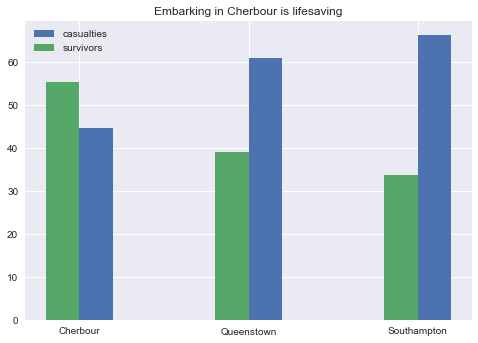

In [130]:
tt = embarked_survival.reset_index().set_index('Embarked')
survived = tt[tt['Survived']==0].PassengerId
dead = tt[tt['Survived']==1].PassengerId
plt.bar([1.2,2.2,3.2],survived, width=0.2)
plt.bar([1,2,3],dead,width=0.2)
plt.xticks([1.1,2.1,3.1], ['Cherbour', 'Queenstown', 'Southampton'])
plt.legend(['casualties','survivors'])
plt.title('Embarking in Cherbour is lifesaving')

### Sex matters for survival

In [131]:
train_cat = train.select_dtypes(include='object').copy()
train_cat#value_counts()
[female_n,male_n]=[train.loc[train['Sex']=='female','PassengerId'].count(),train.loc[train['Sex']=='male','PassengerId'].count()]
sex_crosstab=round(pd.crosstab(train.Survived,train.Sex)/[female_n,male_n]*100,1)
print(sex_crosstab)



Sex       female  male
Survived              
0           25.8  81.1
1           74.2  18.9


### Passenger Class

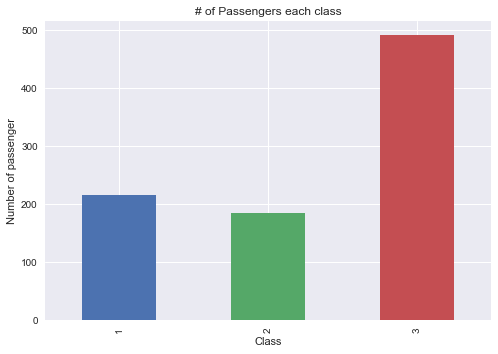

In [132]:

pd.value_counts(train.Pclass).sort_index().plot.bar(title="# of Passengers each class")

plt.ylabel('Number of passenger')
plt.xlabel('Class')
plt.savefig('figures/Pclass.png')

### Age of passengers

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


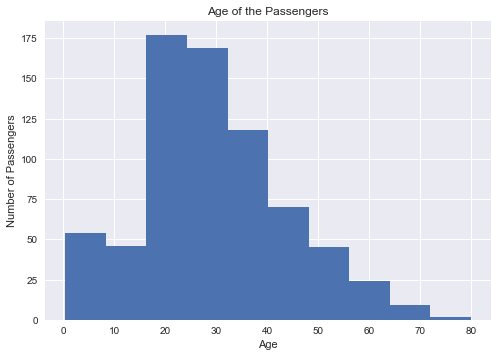

In [135]:
print(train.Age.describe())
train.Age.hist()
plt.title('Age of the Passengers')
plt.ylabel('Number of Passengers')
plt.xlabel('Age')
plt.savefig('ageHist.png')


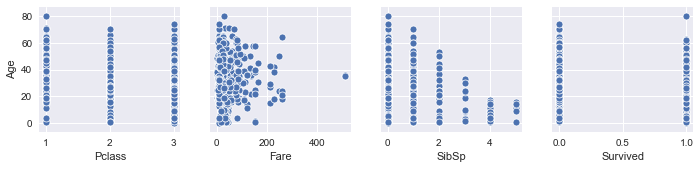

In [136]:
fig_all_about_age = sns.pairplot(train,y_vars=["Age"],x_vars=['Pclass','Fare','SibSp','Survived'])

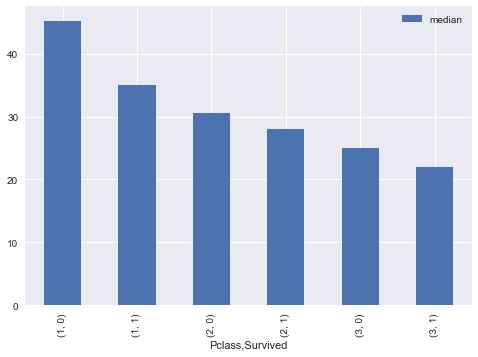

In [240]:
fig_age_class_survive = train.groupby(['Pclass','Survived']).agg(['median'])['Age'].plot(kind='bar')

count    891.00
mean      32.20
std       49.69
min        0.00
25%        7.91
50%       14.45
75%       31.00
max      512.33
Name: Fare, dtype: float64

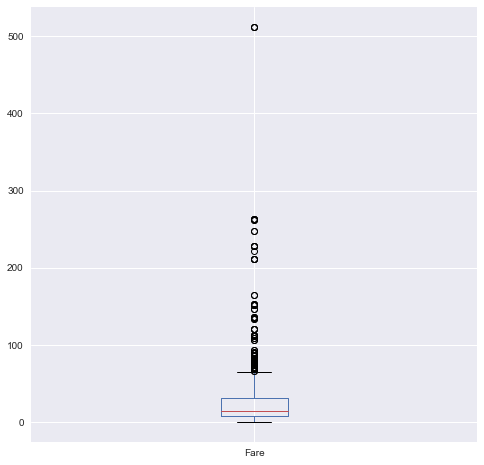

In [241]:
train.Fare.plot(kind='box',figsize=(8,8))
train.Fare.describe().round(2)

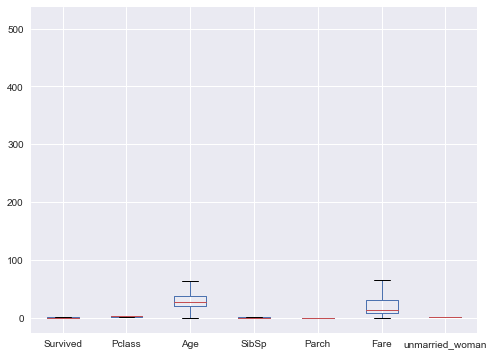

In [99]:
train.iloc[:,train.columns!='PassengerId'].plot(kind='box',figsize=(8,6))

In [244]:
train.corr().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


In [246]:
class_survival=round(train.groupby(['Pclass','Survived']).count()\
                     ['PassengerId']/train.groupby('Pclass').count()['PassengerId']*100,2)


In [247]:
class_survival=round(train.groupby(['Pclass','Survived'])['PassengerId'].agg('count')\
                    /train.groupby('Pclass').count()['PassengerId']*100,2)
class_survival

Pclass  Survived
1       0           37.04
        1           62.96
2       0           52.72
        1           47.28
3       0           75.76
        1           24.24
Name: PassengerId, dtype: float64

Text(0.5, 1.0, 'The class makes a difference')

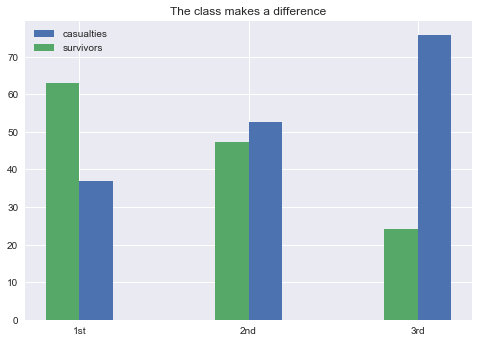

In [248]:
tt = class_survival.reset_index().set_index('Pclass')
survived = tt[tt['Survived']==0].PassengerId
dead = tt[tt['Survived']==1].PassengerId
plt.bar([1.2,2.2,3.2],survived, width=0.2)
plt.bar([1,2,3],dead,width=0.2)
plt.xticks([1.1,2.1,3.1], ['1st', '2nd', '3rd'])
plt.legend(['casualties','survivors'])
plt.title('The class makes a difference')

## Let's start filling the missings

In [84]:
train.Age = train.Age.fillna(train.Age.median())

In [85]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [86]:
train.Embarked = train.Embarked.fillna('S')